# Bootstrap Simulations

The point of this is to investigate several methods for bootstrapping to see which appears to work best in our situation.

The setup:

* 35 groups
* Each with a define prediction distribution and actual distribution
* Run once with big sample size to estimate "true" mean MAE, MMAE
* Run again with smaller sample size, and test multiple bootstrapping strategies
    * Just the group MAEs
    * Groups and predictions within groups
    * Just predictions within groups
    * Groups overall
* Repeat many times and compare:
    * How well calibrated different methods are
    * How wide intervals are


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

plt.style.use("ggplot")

## Distribution Generation

Generate random prediction and actual "true" distribution parameters. For now, using all normals

In [79]:
rng_det = np.random.default_rng(5)
ngrps = 35

pred_mus = rng_det.normal(0, 1, size=ngrps)
act_mus = rng_det.normal(0.5, 1, size=ngrps)
pred_stds = np.exp(rng_det.normal(0, 0.1, size=ngrps))
act_stds = np.exp(rng_det.normal(0, 0.2, size=ngrps))

def sample_gen(samples):
    rng = np.random.default_rng()
    res_arr = np.zeros((samples.sum(), 2))
    idx = 0
    for act_mu, act_std, pred_mu, pred_std, n in zip(act_mus, act_stds, pred_mus, pred_stds, samples):
        res_arr[idx: idx + n, 0] = rng.normal(act_mu, act_std, size=n)
        res_arr[idx: idx + n, 1] = rng.normal(pred_mu, pred_std, size=n)
        idx += n
    res_df = pd.DataFrame(res_arr, columns=["act", "pred"])
    res_df["err"] = (res_df.act - res_df.pred).abs()
    res_df["grp"] = np.repeat(np.arange(len(samples)), samples)
    return res_df

def calc_mae(df):
    return df.groupby("grp")["err"].mean().mean()

## Estimate "True" MMAE

Set sample size high and estimate the True value

In [80]:
tv_list = []
for _ in range(5):
    curr_val = calc_mae(sample_gen(np.repeat(1000000, ngrps)))
    print(curr_val)
    tv_list.append(curr_val)
tv = np.mean(tv_list)

1.6358914479901197
1.6360723709827054
1.6359199418120767
1.6359510029116053
1.636033080539358


## Bootstrap Testing

For each method:

1. Generate a dataset
2. Bootstrap CIs at levels:
   1. 50
   2. 80
   3. 95
3. Save the following
   1. Width of each
   2. Whether true value is in CI
4. Repeat many times



In [81]:
levels = [50, 80, 95]

def agg_bootstrap(boot_sims, id):
    res_list = []
    for lev in levels:
        row = {}
        a = (1 - lev/100) / 2
        lower, upper = a, 1 - a


        # Save
        row["level"] = lev
        row["lower"] = np.quantile(boot_sims, lower)
        row["upper"] = np.quantile(boot_sims, upper)
        row["id"] = id
        res_list.append(row)
    return res_list


In [82]:
# Parameters for comparisons
ntrials = 500
nboot = 100
samples = np.random.negative_binomial(7, 0.05, size=ngrps)
samples

array([ 84, 110,  76, 111, 157, 102, 198, 115, 133,  69, 101, 106, 100,
       167,  89, 111, 145,  56, 192,  94, 146,  62,  53, 104, 145,  94,
        72, 148,  95, 145, 123,  75, 143, 136, 103])

### Method 1: Bootstrapping Group Means Only

In [83]:
lst = []
for i in range(ntrials):
    boot_est = np.zeros(nboot)
    data = sample_gen(samples)
    grp_means = data.groupby("grp")["err"].mean()
    for b in range(nboot):
        boot_est[b] = grp_means.sample(ngrps, replace=True).mean()

    # Eval
    lst.extend(agg_bootstrap(boot_est, i))

boot1 = pd.DataFrame(lst)
boot1

,level,lower,upper,id
0,50,1.570046,1.705372,0
1,80,1.503123,1.770708,0
2,95,1.465574,1.860692,0
3,50,1.520915,1.663806,1
4,80,1.459907,1.723528,1
...,...,...,...,...
1495,80,1.524910,1.781933,498
1496,95,1.440034,1.855304,498
1497,50,1.562956,1.696930,499
1498,80,1.480241,1.744723,499


### Method 2: Bootstrapping Groups and Predictions within Groups

On each iteration:

1. bootstrap sample of groups
2. bootstrap sample of points within each group


In [84]:
lst = []
for i in tqdm(range(ntrials)):
    boot_est = np.zeros(nboot)
    data = sample_gen(samples)

    # Gen boot
    tmp = data.merge(pd.DataFrame({"grp": np.random.choice(data.grp.unique(), size=ngrps, replace=True), "boot_id": np.arange(ngrps)}))
    for b in range(nboot):
        boot_est[b] = tmp.groupby("boot_id")["err"].sample(frac=1, replace=True).mean().mean()

    # Eval
    lst.extend(agg_bootstrap(boot_est, i))

boot2 = pd.DataFrame(lst)
boot2

100%|██████████| 500/500 [03:10<00:00,  2.62it/s]


,level,lower,upper,id
0,50,1.604575,1.624637,0
1,80,1.600881,1.634207,0
2,95,1.591801,1.646447,0
3,50,1.458926,1.480073,1
4,80,1.447209,1.489794,1
...,...,...,...,...
1495,80,1.434194,1.473976,498
1496,95,1.426669,1.483014,498
1497,50,1.645689,1.669105,499
1498,80,1.636353,1.680731,499


### Method 3: Bootstrapping Predictions within Groups only

In [86]:
lst = []
for i in tqdm(range(ntrials)):
    boot_est = np.zeros(nboot)
    data = sample_gen(samples)

    # Gen boot
    for b in range(nboot):
        boot_est[b] = data.groupby("grp")["err"].sample(frac=1, replace=True).mean().mean()

    # Eval
    lst.extend(agg_bootstrap(boot_est, i))

boot3 = pd.DataFrame(lst)
boot3

100%|██████████| 500/500 [03:23<00:00,  2.46it/s]


,level,lower,upper,id
0,50,1.592670,1.616548,0
1,80,1.585708,1.625608,0
2,95,1.571430,1.639908,0
3,50,1.591108,1.610934,1
4,80,1.585185,1.624444,1
...,...,...,...,...
1495,80,1.575378,1.630395,498
1496,95,1.561977,1.638106,498
1497,50,1.590442,1.608383,499
1498,80,1.578606,1.619242,499


### Method 4: Bootstrapping All Predictions


In [87]:
lst = []
for i in tqdm(range(ntrials)):
    boot_est = np.zeros(nboot)
    data = sample_gen(samples)

    # Gen boot
    for b in range(nboot):
        boot_est[b] = data.sample(frac=1, replace=True).groupby("grp")["err"].mean().mean()

    # Eval
    lst.extend(agg_bootstrap(boot_est, i))

boot4 = pd.DataFrame(lst)
boot4

100%|██████████| 500/500 [01:08<00:00,  7.27it/s]


,level,lower,upper,id
0,50,1.605537,1.629860,0
1,80,1.595298,1.637836,0
2,95,1.585209,1.643698,0
3,50,1.642948,1.669822,1
4,80,1.632062,1.680409,1
...,...,...,...,...
1495,80,1.640554,1.690312,498
1496,95,1.627872,1.701974,498
1497,50,1.616103,1.641513,499
1498,80,1.601326,1.652266,499


## Comparison and Evaluation

In [94]:
row_list = []
for i, df in enumerate([boot1, boot2, boot3, boot4]):
    name = f"boot{i + 1}"
    for lev in levels:
        row = {}
        tmp = df[df.level == lev].copy()
        tmp["gap"] = tmp.upper - tmp.lower
        row["avg_width"] = tmp.groupby("level")["gap"].mean().iloc[0]
        cov = ((tmp.upper > tv) & (tmp.lower < tv))#.mean()
        cov_boot = np.zeros(100)
        for b in range(100):
            cov_boot[b] = np.random.choice(cov, len(cov), replace=True).mean()
        
        row["coverage"] = cov.mean()
        row["coverage_lower"] = np.quantile(cov_boot, q=0.025)
        row["coverage_upper"] = np.quantile(cov_boot, q=0.975)

        row["level"] = lev
        row["method"] = name
        row_list.append(row)
res = pd.DataFrame(row_list)
res

,avg_width,coverage,coverage_lower,coverage_upper,level,method
0,0.139628,0.994,0.98800,0.99905,50,boot1
1,0.265077,1.000,1.00000,1.00000,80,boot1
2,0.396190,1.000,1.00000,1.00000,95,boot1
3,0.022549,0.086,0.06200,0.10705,50,boot2
4,0.042728,0.158,0.13295,0.18200,80,boot2
5,0.063600,0.238,0.20190,0.27400,95,boot2
6,0.022744,0.070,0.04790,0.09200,50,boot3
7,0.042654,0.174,0.14295,0.20725,80,boot3
8,0.063771,0.352,0.31695,0.38810,95,boot3
9,0.024176,0.490,0.45295,0.53915,50,boot4


In [95]:
# Rename method
rename = {
    "boot1": "Groups Only",
    "boot2": "Groups and Predictions within Groups",
    "boot3": "Predictions within Groups Only",
    "boot4": "All Predictions"
}
res.method = res.method.map(rename)
res

,avg_width,coverage,coverage_lower,coverage_upper,level,method
0,0.139628,0.994,0.98800,0.99905,50,Groups Only
1,0.265077,1.000,1.00000,1.00000,80,Groups Only
2,0.396190,1.000,1.00000,1.00000,95,Groups Only
3,0.022549,0.086,0.06200,0.10705,50,Groups and Predictions within Groups
4,0.042728,0.158,0.13295,0.18200,80,Groups and Predictions within Groups
5,0.063600,0.238,0.20190,0.27400,95,Groups and Predictions within Groups
6,0.022744,0.070,0.04790,0.09200,50,Predictions within Groups Only
7,0.042654,0.174,0.14295,0.20725,80,Predictions within Groups Only
8,0.063771,0.352,0.31695,0.38810,95,Predictions within Groups Only
9,0.024176,0.490,0.45295,0.53915,50,All Predictions


### Plotting

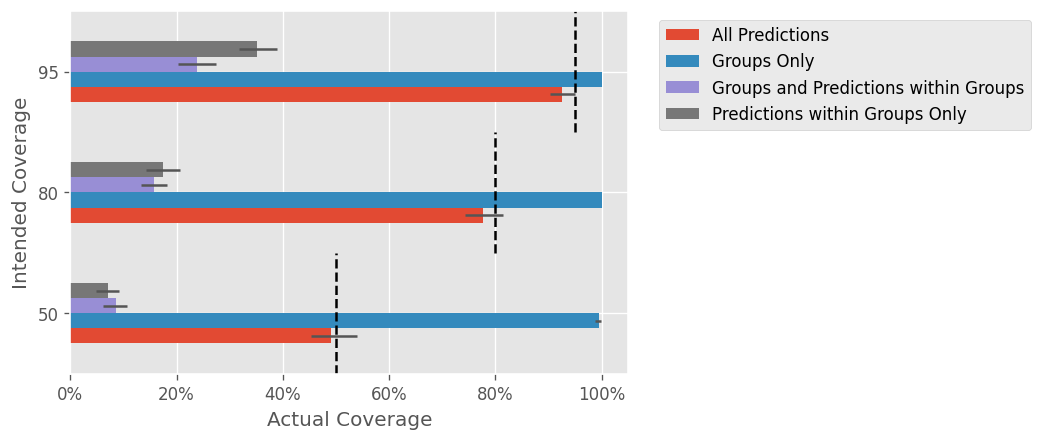

In [106]:
piv = pd.pivot_table(res, index="level", columns="method", values="coverage")
lower_bnd = pd.pivot_table(res, index="level", columns="method", values="coverage_lower")
upper_bnd = pd.pivot_table(res, index="level", columns="method", values="coverage_upper")
errors = [[piv[c] - lower_bnd[c], upper_bnd[c] - piv[c]] for c in piv.columns]

fig, ax = plt.subplots(dpi=120)

for i, lev in enumerate(levels):
    ax.axvline(lev / 100, ymin=i/3, ymax=(i + 1) /3, ls="--", color="k")

piv.plot.barh(ax=ax, xerr=errors)
ax.xaxis.set_major_formatter("{x:.0%}")
ax.set_xlabel("Actual Coverage")
ax.set_ylabel("Intended Coverage")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.savefig("images/cov.png", bbox_inches="tight")
plt.show()

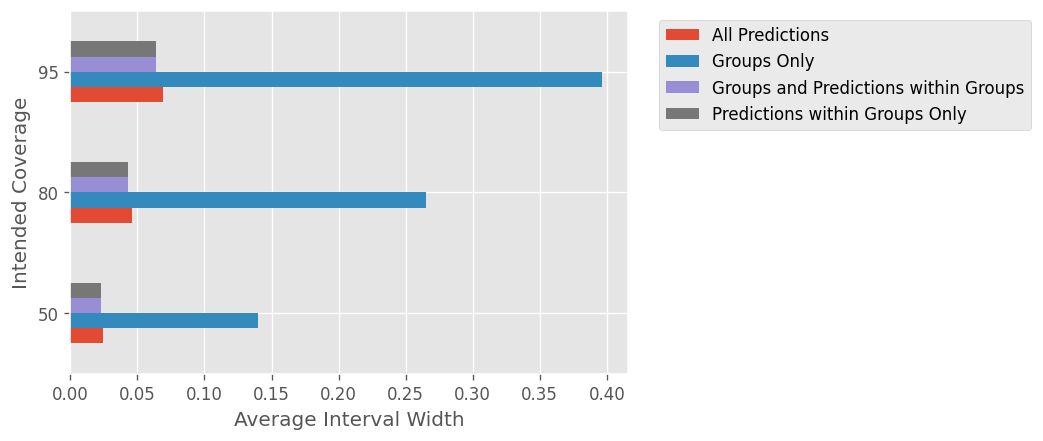

In [107]:
piv = pd.pivot_table(res, index="level", columns="method", values="avg_width")

fig, ax = plt.subplots(dpi=120)
piv.plot.barh(ax=ax)
ax.set_xlabel("Average Interval Width")
ax.set_ylabel("Intended Coverage")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.savefig("images/width.png", bbox_inches="tight")
plt.show()